# BDT in TopFC analysis
Author: Meisam Ghasemi Bostanabad

## Loading `pandas` DataFrames
Now we load two different `NumPy` arrays. One corresponding to the VV signal and one corresponding to the background.

In [1]:
import uproot
import numpy as np
import pandas as pd
import h5py
import awkward as ak
import seaborn as sns
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_charm':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_charm.root'
    }

'''
filename = {
    'ttbar':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ttbar.root',
    'WZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/WZ.root',
    'ZZ':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/ZZ.root',
    'signal_up':'/Users/mghasemi/Desktop/IPM/plotter/newtrees/signal_up.root'}
    }
'''

upfile = {}
params = {}
df = {}

# choose which vars to use (multi dimensional)
#VARS = ['jetNo','jetPTLeading','bjetPT','elecPTLeading','met','testnonTopMass', 'weight'] # choose which vars to use (2d)
VARS = ['jetNo','jetPTLeading', 'jetETA', 'jetPHI','bjetPT', 'bjetETA',
        'elecPTLeading', 'elecETA', 'elecPHI',
        'dielecCOS', 'dielecETA', 'met','testnonTopMass'] # choose which vars to use (2d)

# define trees and branches to make DataFrame
for treename in filename.keys():
    upfile[treename] = uproot.open(filename[treename])
    params[treename] = upfile[treename][treename].arrays(VARS)
    df[treename] = ak.to_dataframe(params[treename])
    # add isSignal variable
    if treename.startswith("signal"): 
        df[treename]['isSignal'] = np.ones(len(df[treename])) 
    else:
        df[treename]['isSignal'] = np.zeros(len(df[treename])) 

## Data exploration

In [2]:
# reduce signal DF size to have resonable Sig/Bkg ratio
df['signal_charm'] = df['signal_charm'][:3500]
df_all = pd.concat([df[treename] for treename in filename.keys()])

In [42]:
# number of entries in the backgrounds and signals
tot_bkg = 0
for treename in filename.keys():
    if not 'signal' in treename: tot_bkg += df[treename].shape[0]
    print(treename, ":", df[treename].shape)

print("signal/tot bkg:", round((df['signal_charm'].shape[0]/ tot_bkg),1))
#print("Null entries:", df['signal_charm'].isna().sum())

ttbar : (915, 14)
WZ : (2176, 14)
ZZ : (174, 14)
signal_charm : (94643, 14)
signal/tot bkg: 29.0


In [4]:
# function to make ML output and significant plot
samples =['ttbar', 'WZ', 'ZZ', 'signal_charm']

def plot_SoverB(data, SoverB_hist_dict):
    
    signal = r'signal_charm' # which sample is the signal

    # *******************
    # general definitions (shouldn't need to change)

    for x_variable,hist in SoverB_hist_dict.items(): # access the dictionary of histograms defined in the cell above

        h_bin_width = hist['bin_width'] # get the bin width defined in the cell above
        h_num_bins = hist['num_bins'] # get the number of bins defined in the cell above
        h_xrange_min = hist['xrange_min'] # get the x-range minimum defined in the cell above
        h_xlabel = hist['xlabel'] # get the x-axis label defined in the cell above
    
        bin_edges = [ h_xrange_min + x*h_bin_width for x in range(h_num_bins+1) ] # bin limits
        bin_centres = [ h_xrange_min+h_bin_width/2 + x*h_bin_width for x in range(h_num_bins) ] # bin centres
        
        signal_x = data[signal][x_variable] # histogram the signal
    
        mc_x = [] # define list to hold the Monte Carlo histogram entries

        for s in samples: # loop over samples
            if s not in ['data', signal]: # if not data nor signal
                mc_x = [*mc_x, *data[s][x_variable] ] # append to the list of Monte Carlo histogram entries
                #test=[]; test.append(df[s]['NN_output_prob'].values)


    
    
        # *************
        # Signal and background distributions
        # *************
        distributions_axes = plt.gca() # get current axes
 
        mc_heights = distributions_axes.hist(mc_x, bins=bin_edges, color='red', 
                                             label='Total background',
                                             histtype='step', # lineplot that's unfilled
                                             density=True ) # normalize to form probability density
        signal_heights = distributions_axes.hist(signal_x, bins=bin_edges, color='blue',
                                                 label=signal, 
                                                 histtype='step', # lineplot that's unfilled
                                                 density=True, # normalize to form probability density
                                                 linestyle='--' ) # dashed line
        
        distributions_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # x-limits of the distributions axes
        distributions_axes.set_ylabel('Arbitrary units' ) # y-axis label for distributions axes
        y_max = max(max(signal_heights[0]), max(mc_heights[0]) )
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        distributions_axes.set_ylim( top=y_max*1.2 ) # set y-axis limits
        #distributions_axes.set_ylim( top=max(signal_heights[0])*1.3 ) # set y-axis limits
        plt.title('Signal and background '+x_variable+' distributions') # add title
        distributions_axes.legend() # draw the legend
        distributions_axes.set_xlabel( h_xlabel ) # x-axis label
            
        plt.show() # show the Signal and background distributions
    
    
        # *************
        # Signal to background ratio
        # *************
        plt.figure() # start new figure
        SoverB = [] # list to hold S/B values
        for cut_value in bin_edges: # loop over bins
            #signal_weights_passing_cut = sum(data[signal][data[signal][x_variable]>cut_value].totalWeight)
            signal_weights_passing_cut = len(data[signal][data[signal][x_variable]>cut_value])
            background_weights_passing_cut = 0 # start counter for background weights passing cut
            for s in samples: # loop over samples
                if s not in ['data', signal]: # if not data nor signal
                    #background_weights_passing_cut += sum(data[s][data[s][x_variable]>cut_value].totalWeight)
                    background_weights_passing_cut += len(data[s][data[s][x_variable]>cut_value])
            if background_weights_passing_cut!=0: # some background passes cut
                SoverB_value = signal_weights_passing_cut/background_weights_passing_cut
                SoverB_percent = 100*SoverB_value # multiply by 100 for percentage
                SoverB.append(SoverB_percent) # append to list of S/B values
        
        SoverB_axes = plt.gca() # get current axes
        SoverB_axes.plot( bin_edges[:len(SoverB)], SoverB ) # plot the data points
        SoverB_axes.set_xlim( left=bin_edges[0], right=bin_edges[-1] ) # set the x-limit of the main axes
        #SoverB_axes.set_ylim( 100, 1000)
        SoverB_axes.set_ylabel( 'S/B (%)' ) # write y-axis label for main axes
        plt.title('Signal to background ratio for different '+x_variable+' cut values', family='sans-serif')
        SoverB_axes.set_xlabel( h_xlabel ) # x-axis label 
        
        plt.show() # show S/B plot
    
    return

## simple BDT in sklearn
In gradient boosting, an ensemble of weak learners is used to improve the performance of a machine learning model. The weak learners are usually decision trees. Combined, their output results in better models. 

In [26]:
#dtree.predict_proba(scaler.transform(X))
#dtree.predict(scaler.transform(X))
dtree.decision_function(scaler.transform(X))

AttributeError: 'DecisionTreeClassifier' object has no attribute 'decision_function'

Accuracy score report for the test set
0.8625167935512763
Accuracy score report for the total set
0.9546193643754619

Classification report for the test set
              precision    recall  f1-score   support

  background       0.85      0.88      0.86      1083
      signal       0.88      0.85      0.86      1150

    accuracy                           0.86      2233
   macro avg       0.86      0.86      0.86      2233
weighted avg       0.86      0.86      0.86      2233


Classification report for the total set
              precision    recall  f1-score   support

  background       0.95      0.96      0.95      3265
      signal       0.96      0.95      0.96      3500

    accuracy                           0.95      6765
   macro avg       0.95      0.95      0.95      6765
weighted avg       0.95      0.95      0.95      6765



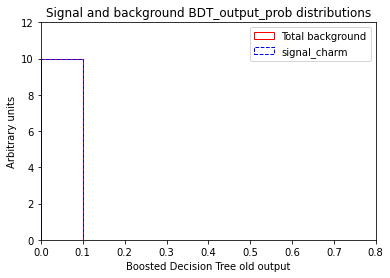

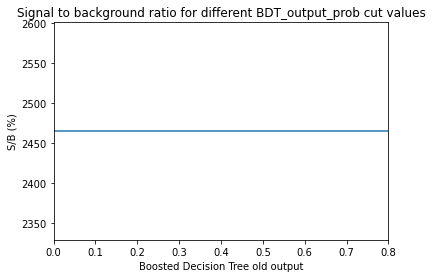

In [36]:
NDIM = len(VARS)
dataset = df_all.values
X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# baseline keras model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix


dtree = DecisionTreeClassifier()
dtree.fit(X_train_val, Y_train_val)

y_pred_BDT = dtree.predict(X_test)
y_pred_BDT_tot = dtree.predict(scaler.transform(X))

print("Accuracy score report for the test set")
print(accuracy_score(Y_test,y_pred_BDT))
print("Accuracy score report for the total set")
print(accuracy_score(Y,y_pred_BDT_tot))

print("\nClassification report for the test set")
print(classification_report(Y_test.round(), y_pred_BDT.round(), target_names=['background', 'signal']))
print("\nClassification report for the total set")
print(classification_report(Y.round(), y_pred_BDT_tot.round(), target_names=['background', 'signal']))

fpr_bdt_old, tpr_bdt_old, thresholds_bdt_old = roc_curve(Y_test, y_pred_BDT)

df_all['dense_BDT'] = dtree.predict(scaler.transform(X)) # add prediction to array

# add old BDT probability
y_tot_prob_BDT = dtree.predict_proba(scaler.transform(X))[:,1]
y_tot_BDT = dtree.predict(scaler.transform(X))
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['BDT_output_prob'] = y_tot_prob_BDT[cumulative_events:cumulative_events+len(df[key])]
    df[key]['BDT_output'] = y_tot_BDT[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events

# probability and significance plots
BDT_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Boosted Decision Tree old output', # x-axis label
}

SoverB_hist_dict = {'BDT_output_prob':BDT_output_prob}
plot_SoverB(df, SoverB_hist_dict)

In [37]:
dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

## Optimized BDT

Time taken to fit BDT: 0.5s
AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=6),
                   learning_rate=0.5, n_estimators=12)
0.7250335871025526
Classification report for the test set
              precision    recall  f1-score   support

  background       0.75      0.66      0.70      1083
      signal       0.71      0.79      0.75      1150

    accuracy                           0.73      2233
   macro avg       0.73      0.72      0.72      2233
weighted avg       0.73      0.73      0.72      2233

Classification report for the total set
              precision    recall  f1-score   support

  background       0.78      0.71      0.75      3265
      signal       0.75      0.82      0.78      3500

    accuracy                           0.77      6765
   macro avg       0.77      0.76      0.76      6765
weighted avg       0.77      0.77      0.76      6765



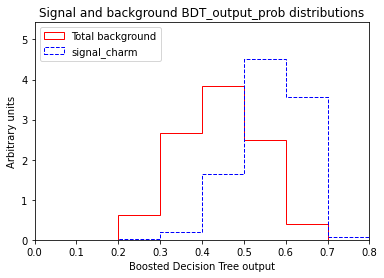

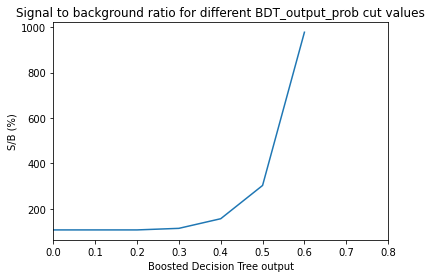

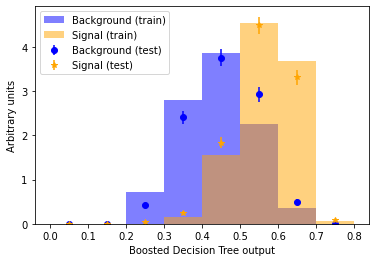

In [44]:
import time
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth=6) # maximum depth of the tree
bdt = AdaBoostClassifier(dt,
                        algorithm='SAMME', # SAMME discrete boosting algorithm
                        n_estimators=12, # max number of estimators at which boosting is terminated
                        learning_rate=0.5) # shrinks the contribution of each classifier by learning_rate

start = time.time() # time at start of BDT fit
bdt.fit(X_train_val, Y_train_val) # fit BDT to training set
elapsed = time.time() - start # time after fitting BDT
print("Time taken to fit BDT: "+str(round(elapsed,1))+"s") # print total time taken to fit BDT
print(bdt)


# performance plots
y_pred_BDT = bdt.predict(X_test)
y_pred_BDT_tot = bdt.predict(scaler.transform(X))
print(accuracy_score(Y_test,y_pred_BDT))
print("Classification report for the test set")
print(classification_report(Y_test, y_pred_BDT, target_names=['background', 'signal']))
print("Classification report for the total set")
print(classification_report(Y, y_pred_BDT_tot, target_names=['background', 'signal']))

fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(Y_test, y_pred_BDT)

df_all['dense_BDT_opt'] = bdt.predict(scaler.transform(X)) # add prediction to array

# add RF probability
y_tot_prob_BDT = bdt.predict_proba(scaler.transform(X))[:,1]
y_tot_BDT = bdt.predict(scaler.transform(X))
cumulative_events = 0 # start counter for total number of events for which output is saved
for key in filename.keys(): # loop over samples
    df[key]['BDT_output_prob'] = y_tot_prob_BDT[cumulative_events:cumulative_events+len(df[key])]
    df[key]['BDT_output'] = y_tot_BDT[cumulative_events:cumulative_events+len(df[key])]
    cumulative_events += len(df[key]) # increment counter for total number of events


# probability and significance plots
BDT_output_prob = { # dictionary containing plotting parameters for the mllll histogram
    # change plotting parameters
    'bin_width':0.1, # width of each histogram bin
    'num_bins':8, # number of histogram bins
    'xrange_min':0, # minimum on x-axis
    'xlabel':'Boosted Decision Tree output', # x-axis label
}

SoverB_hist_dict = {'BDT_output_prob':BDT_output_prob}
plot_SoverB(df, SoverB_hist_dict)    

# plot ROC curve
'''
plt.plot(fpr_bdt, tpr_bdt, label='Boosted Decision Tree') # plot random forest ROC
plt.plot([0, 1], [0, 1], linestyle='dotted', color='grey', label='Luck') # plot diagonal line to indicate luck
plt.xlabel('False Positive Rate') # x-axis label
plt.ylabel('True Positive Rate') # y-axis label
plt.grid() # add a grid to the plot
plt.legend(); # add a legend
'''

# overfit checking
def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel):
    decisions = [] # list to hold decisions of classifier
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        d1 = clf.predict_proba(X[y<0.5])[:, 1] # background
        d2 = clf.predict_proba(X[y>0.5])[:, 1] # signal
        decisions += [d1, d2] # add to list of classifier decision

    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = -0.1 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.1 # increment
        bin_edges.append(bin_edge)

    # Training plots
    plt.hist(decisions[0], # background in train set
            bins=bin_edges, # lower and upper range of the bins
            density=True, # area under the histogram will sum to 1
            histtype='stepfilled', # lineplot that's filled
            color='blue', label='Background (train)', # Background (train)
            alpha=0.5 ) # half transparency
    plt.hist(decisions[1], # signal in train set
            bins=bin_edges, # lower and upper range of the bins
            density=True, # area under the histogram will sum to 1
            histtype='stepfilled', # lineplot that's filled
            color='orange', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency

    # Testing plots
    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                            bins=bin_edges, # number of bins in function definition
                                            density=True ) # area under the histogram will sum to 1

    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres

    plt.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                c='blue', label='Background (test)' ) # Background (test)

    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                        bins=bin_edges, # number of bins in function definition
                                        density=True ) # area under the histogram will sum to 1

    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background

    plt.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='*', # circles
                c='orange', label='Signal (test)' ) # Signal (test)

    plt.xlabel(xlabel) # write x-axis label
    plt.ylabel("Arbitrary units") # write y-axis label
    plt.legend() # add legend

compare_train_test(bdt, X_train_val, Y_train_val, X_test, Y_test, 'Boosted Decision Tree output')